In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from matplotlib.patches import Circle
from scipy.special import gamma
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad, nquad
import matplotlib.patches as patches
from itertools import product
from scipy.integrate import quad
import scipy.optimize as optimize
from  scipy.interpolate import interp1d
from scipy.misc import derivative
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import glob
from unsio import *
import os
import wkbl
from wkbl.astro.halo_info import *
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import proj3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
import datetime
from scipy.misc import derivative
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [3]:
### General block ###
# general variables 
hydro = wkbl.astro.halo_info.HALOBHydro()
dmo = wkbl.astro.halo_info.HALOBdmo()

### Loading and centering 

In [4]:
##### LOAD And CENTER ####
simname=hydro.name
myhydro = wkbl.Galaxy_Hound(hydro.path)
# uncomment to calculate the dens center of stars
#ok,rho,_= CF.getDensity(np.array(myhydro.st.pos3d.reshape(len(myhydro.st.pos3d)*3),dtype=np.float32), myhydro.st.mass)
#centro_rho = myhydro.st.pos3d[np.where(rho == rho.max())][0]
#centro_rho
#sys.exit()
#print myhydro.dm.pos3d[:,0].max()
myhydro.center_shift(hydro.c_rho_st)
myhydro.r_virial(600,n=16)


loading Dark matter..
loading Stars..
loading Gas..
| r_200 = 177.54
| Diagonal matrix computed 
|    | 19, 0, 0|
| D =| 0, 14, 0|
|    | 0,  0, 2|


In [5]:
## some arrays needed to compute the potential using all elements of simu GAS, STARS and DM
# positions
pos_dm = np.array(myhydro.dm.pos3d.reshape(len(myhydro.dm.pos3d)*3),dtype=np.float32)
pos_gs = np.array(myhydro.gs.pos3d.reshape(len(myhydro.gs.pos3d)*3),dtype=np.float32)
pos_st = np.array(myhydro.st.pos3d.reshape(len(myhydro.st.pos3d)*3),dtype=np.float32)
pos = np.concatenate((pos_dm, pos_st, pos_gs))
phi_cord = np.concatenate((myhydro.dm.phi,myhydro.st.phi, myhydro.gs.phi))
# mass
mass = np.concatenate((myhydro.dm.mass,myhydro.st.mass,myhydro.gs.mass))
# veloicetis
v = np.concatenate((myhydro.dm.v,myhydro.st.v,myhydro.gs.v))
print len(mass)*3, len(pos)
pos3d = pos.reshape(len(pos)/3,3)
#radius
r2 = pos3d[:,0]**2 + pos3d[:,1]**2 +pos3d[:,2]**2

163627989 163627989


In [6]:
# computes potential using all elements in simu
ok, acc, Phy = CF.getGravity(pos,mass,0.15,G=myhydro.p.G)
# units in Msun km^2 s^{-2}
Phy = Phy * myhydro.p.kpctokm**2

In [7]:
(pos3d[r2<100])[Phy[r2<100]==Phy[r2<100].min()]

array([[-0.01603403,  0.00760869, -0.00543651]], dtype=float32)

In [8]:
### eliminate?
"""
def binning_a_bel(minimum,mean,maximum,bins):
    "most efficient way of binning a bell curve"
    a = np.logspace(np.log10(0.15*maximum),np.log10(maximum-mean),bins/2)
    b = np.logspace(np.log10(0.15*maximum),np.log10(mean-minimum),bins/2)
    second_part = mean+ a - a[0]
    first_part = (mean-b+b[0])[::-1]
    return np.concatenate([[minimum],first_part, second_part[1:],[maximum]])
"""

'\ndef binning_a_bel(minimum,mean,maximum,bins):\n    "most efficient way of binning a bell curve"\n    a = np.logspace(np.log10(0.15*maximum),np.log10(maximum-mean),bins/2)\n    b = np.logspace(np.log10(0.15*maximum),np.log10(mean-minimum),bins/2)\n    second_part = mean+ a - a[0]\n    first_part = (mean-b+b[0])[::-1]\n    return np.concatenate([[minimum],first_part, second_part[1:],[maximum]])\n'

### Building histograms in $r$ and $v$ to compute $f(\mathcal{E})$ 

In [9]:
%%latex
We first define equipopulated bins in r, with enough particles to effectively sample the velocity distribution in each bin, $n_{bin} \sim 15000 - 30000 $
. We then build the vdf in each bin in r with 100 bins in v from 0 to the local $v_{max}$. 

<IPython.core.display.Latex object>

In [10]:
# equipoulated bins
# max of halo and in_halo condition
endR = hydro.rmax
in_halo = np.where((myhydro.dm.r>1.)&(myhydro.dm.r<endR))#&((myhydro.dm.r>2.*myhydro.gs.hsml)))
sorted_r = np.argsort(myhydro.dm.r[in_halo])
# numner of particles per bin
part_per_bin = 15000
# total of particles in halo
N_total = len(myhydro.dm.mass[in_halo])
# once sorted it is easy to know the radius of the edges of the bins
bins_index = sorted_r[np.linspace(0,N_total-1,N_total/part_per_bin,dtype=int)]
bins_in_r = (myhydro.dm.r[in_halo])[bins_index]



In [11]:
# centers and width of bins
bins_centers = (bins_in_r[1:]+bins_in_r[:-1])/2.
bins_width = (bins_in_r[1:]-bins_in_r[:-1])
# number of bins in v
length_v = 100
phi_r = np.array([])
##### build arrays by defining them with the fist iteration
# all particles in first bin
selection = np.where((myhydro.dm.r>3*myhydro.gs.hsml.min())&(myhydro.dm.r>bins_in_r[0])&(myhydro.dm.r<bins_in_r[1]))
# mean Potential per bin
phi_r = np.append(phi_r,np.mean(Phy[selection]))
# define array of values of the particles in first bin
my_Vs = myhydro.dm.v[selection]
my_rs = myhydro.dm.r[selection]
# first iteration
r_width = bins_in_r[1]-bins_in_r[0]
# bins pertinents arrays
bins_in_v = np.linspace(my_Vs.min(),my_Vs.max(),length_v+1)#binning_a_bel(my_Vs.min(),np.mean(my_Vs),my_Vs.max(),length_v)
bins_in_v_centers = (bins_in_v[1:] +bins_in_v[:-1])/2
bins_in_v_width = (bins_in_v[1:] - bins_in_v[:-1])
# full array of particles per r and v
# dN^2 / dr /dv
bin_master_array = np.vstack([bins_in_v])
bin_master_centers = np.vstack([bins_in_v_centers])
# Delta_v
bin_master_width = np.vstack([bins_in_v_width])
# Delta_r*Delta_v
bin_master_width2 = np.vstack([r_width*bins_in_v_width])
# histogram in v  inside the bin in r with two different weights
f_v, _ = np.histogram(my_Vs,bins=bins_in_v)
f_v_method2, _ = np.histogram(my_Vs,bins=bins_in_v, weights=1./((4*np.pi*my_Vs*my_rs)**2))
# full histograms
hist_master_array = np.vstack([f_v])
hist_master_array_method2 = np.vstack([f_v_method2])
mass_in, _ = np.histogram(my_Vs,bins=bins_in_v,weights=myhydro.dm.mass[selection])
mass_master_array = np.vstack([mass_in])
# iterates over r bins
for i in range(1,len(bins_in_r)-1):
    #defindes the shell
    selection = np.where((myhydro.dm.r>3*myhydro.gs.hsml.min())&(myhydro.dm.r>bins_in_r[i])&(myhydro.dm.r<=bins_in_r[i+1]))
    r_width = bins_in_r[i+1]-bins_in_r[i]
    phi_r = np.append(phi_r,np.mean(Phy[selection]))# potential
    my_Vs = myhydro.dm.v[selection]# speed
    my_rs = myhydro.dm.r[selection]# speed
    bins_in_v =np.linspace(my_Vs.min(),my_Vs.max(),length_v+1)# binning of the vdf in the shell
    bins_in_v_centers = (bins_in_v[1:] +bins_in_v[:-1])/2
    bins_in_v_width = (bins_in_v[1:] - bins_in_v[:-1])
    # useful 2d arrays with bins info
    bin_master_array = np.vstack([bin_master_array,bins_in_v]) # 2darray of bins edges
    bin_master_centers = np.vstack([bin_master_centers,bins_in_v_centers]) # bins centers
    bin_master_width = np.vstack([bin_master_width,bins_in_v_width]) # bins v width
    bin_master_width2 = np.vstack([bin_master_width2,r_width*bins_in_v_width]) # Delta r* Delta v
    # fdv for the shell
    f_v, _ = np.histogram(my_Vs,bins=bins_in_v)
  
    f_v_method2, _ = np.histogram(my_Vs,bins=bins_in_v, weights=1./((4*np.pi*my_Vs*my_rs)**2))

    hist_master_array = np.vstack([hist_master_array, f_v])

    hist_master_array_method2 = np.vstack([hist_master_array_method2, f_v_method2])
    mass_in, _ = np.histogram(my_Vs,bins=bins_in_v,weights=myhydro.dm.mass[selection])
    mass_master_array = np.vstack([mass_in])

In [12]:
%%latex
no we have defined the distributions for the first and second method $H_{m1}$ as:
\begin{equation}
H_{m1} = \frac{d^2N}{dr dv}
\end{equation}
and the weighted histogram $H_{m2}$ :
\begin{equation}
H_{m2} = \frac{1}{\left( 4 \pi v r\right)^2 }\frac{d^2N}{dr dv}
\end{equation}

<IPython.core.display.Latex object>

In [13]:
# constructing $v_{esc}$ for each bin in r
r_4_pot = np.linspace(1, hydro.rmax,200)
pot_r, r_4_pot = np.histogram(myhydro.dm.r,bins = r_4_pot, weights=Phy[:len(myhydro.dm.r)])
pot_r2, r_4_pot = np.histogram(myhydro.dm.r,bins = r_4_pot, weights=Phy[:len(myhydro.dm.r)]**2)
n_pot_r, r_4_pot = np.histogram(myhydro.dm.r,bins = r_4_pot)
pot_r /= n_pot_r
pot_r2 /= n_pot_r
std_vesc = pot_r2 - (pot_r)**2 
vesc_r = np.sqrt(2*(Phy.max()-pot_r))
f_vesc_r = interp1d((r_4_pot[1:]+r_4_pot[:-1])/2., vesc_r)
f_vesc_std = interp1d(((r_4_pot[1:]+r_4_pot[:-1])/2.)[std_vesc>0], np.sqrt(std_vesc[std_vesc>0]))

In [14]:
%%latex
once we have the definitions of the normalized potential as:
\begin{equation}
\Psi(r) = \Phi(r_{max})-\Phi(r)
\end{equation}
and the Energy as: 
\begin{equation}
\mathcal{E} = \Psi(r)- \frac{v^2}{2}
\end{equation}
the escape velocity can be define as a function of the gravitational potential in the following way:
\begin{equation}
v_{esc} = \sqrt{2\Psi} = \sqrt{\Phi_{r_{max}} - \Phi_{r}}
\end{equation}


<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


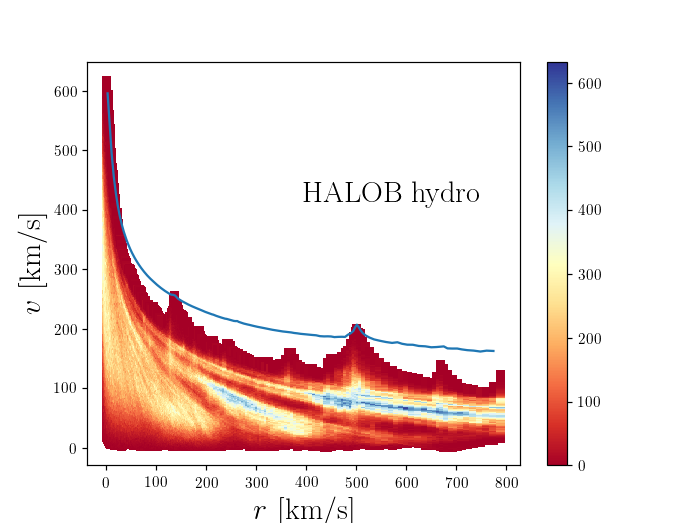

low =  1
upp =  -1
(248, 100)
(248, 100)


Text(394.177,413.235,'$\\rm HALOB\\;hydro$')

In [15]:
fig, ax = plt.subplots()
cmap = plt.cm.get_cmap('RdYlBu')
ax.set_xlabel(r"$ r \,\,\textrm{[km/s]}$",fontsize=20 )
ax.set_ylabel(r"$ v \,\,\textrm{[km/s]}$",fontsize=20)
#ax.set_xlim(0,myhydro.r200)
#ax.set_ylim(0,bin_master_array.max())
R = np.zeros(bin_master_centers.shape)
R_w = np.zeros(bin_master_width.shape)

bins_in_r_center = (bins_in_r[1:]+bins_in_r[:-1])/2
bins_in_r_width = (bins_in_r[1:]-bins_in_r[:-1])

R[:,:] = np.vstack(bins_in_r_center)
R_w[:,:] = np.vstack( bins_in_r_width )

#define range
done=False
# lower limit
low = 0
while  done==False:
    try:
        f_vesc_r(bins_in_r_center[low])
        done=True
    except:
        low+=1
print "low = ",low
done=False
# upper limit
upp = -1
while done==False:
    try:
        f_vesc_r(bins_in_r_center[upp])
        done=True
    except:
        upp-=1
print "upp = ", upp


print R.shape
B = bin_master_centers
print B.shape
COLOR = hist_master_array.reshape(1,len(hist_master_array)*len(hist_master_array[0]))
normalize = mpl.colors.Normalize(vmin=np.nanmin(COLOR[0]), vmax=np.nanmax(COLOR[0]))
colors = [cmap(normalize(value)) for value in np.nan_to_num(COLOR[0])]
sc = ax.scatter( R.reshape(1,len(R)*len(R[0])),B.reshape(1,len(B)*len(B[0])),marker='s',lw=0,c=colors)
cax, _ = mpl.colorbar.make_axes(ax)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
ax.plot(bins_in_r_center[low:upp],f_vesc_r(bins_in_r_center[low:upp]))
ax.text(bins_in_r_center.max()/2,2*bin_master_array.max()/3,r"$\rm "+hydro.namenospace+"\;"+hydro.version+"$", fontsize=20)

### Computing $\Phi_{r_{max}}$ 

In [ ]:
# finds the value of $\Phi_{r_{max}}$ by averaging the shell with $dr\to0$ and $r=r_{max}$
diffe = .02
con = np.where((myhydro.dm.r > (1-diffe)*hydro.rmax)&(myhydro.dm.r < (1+diffe)*hydro.rmax))
maxval = np.mean(Phy[con])
print maxval
#Psi per particle
Psi_all = (maxval - Phy[:len(myhydro.dm.mass)]) / myhydro.dm.mass

In [ ]:
## find and defines teory textfiles
fil = glob.glob("/home/arturo/Documents/LAM/LAM2LUPM/f_of_E/"+hydro.namenospace+"/fE_Eddington_"+hydro.namenospace+"_DM_baryons_*")
f_E_Theory = np.loadtxt(fil[0])
f_E_Theory[:,0]



### Defining $\omega\,\frac{ d^2N}{drdv}
$

In [ ]:
# Psi per radius
Psi = maxval - phi_r
themaxofPsi = Psi.max()
P = np.zeros(bin_master_centers.shape)
P[:,:] = np.vstack(Psi)
# Epsilon per bin
Epsilon = P  -  (bin_master_centers**2) /2.

# method one: central values $\frac{1}{(4\pi r v)^2} \frac{d^2N}{drdv}$
# H_{m1}
N_bins_method1 = myhydro.dm.mass.min() * hist_master_array / R**2 / bin_master_centers**2 /16./ np.pi**2  / bin_master_width / R_w
###
# method 2 weight per particle
# H_{m2}
N_bins_method2 = myhydro.dm.mass.min() * hist_master_array_method2 / bin_master_width2



volshel = (4./3.)*np.pi*(bins_in_r[1:]**3-bins_in_r[:-1]**3)
VOL = np.zeros(bin_master_centers.shape)
VOL[:,:] = np.vstack(volshel)
N_bins = myhydro.dm.mass.min() * hist_master_array / bin_master_centers**2 /4./ np.pi  / bin_master_width / VOL


DN_bins = myhydro.dm.mass.min() * np.sqrt(hist_master_array) / bin_master_centers**2 /4./ np.pi  / bin_master_width / VOL


In [ ]:
# resolution limint \Psi(r_{hsml})
res_lim = (myhydro.dm.r>4*myhydro.gs.hsml.min())&(myhydro.dm.r<4.2*myhydro.gs.hsml.min())
resolutiont_limit_in_epsilonHSML=np.mean(Psi_all[res_lim])/Psi_all.max()

In [ ]:
# reshape the epsilon array from the 2D array to a 1D array
ep_array = np.linspace(Epsilon.min(), Epsilon.max(), 40)
ep_array_center = (ep_array[1:]+ep_array[:-1])/2.
xpoints = Epsilon.reshape(1,len(Epsilon)*len(Epsilon[0]))
points = N_bins_method2.reshape(1,len(N_bins_method2)*len(N_bins_method2[0]))
errpoints = DN_bins.reshape(1,len(DN_bins)*len(DN_bins[0]))


In [ ]:
%%time
#### Moving Window average on Psi data
sorted_by_r = np.argsort(myhydro.dm.r)
r_sor = myhydro.dm.r[sorted_by_r]
v_sor = myhydro.dm.v[sorted_by_r]

Phi = Phy[:len(myhydro.dm.mass)]
Psi_sor = maxval-Phi[sorted_by_r]
window_size = 3000
block_size =200
mow_Psi= Psi_sor[:window_size]
mow_r = r_sor[:window_size]
print np.mean(mow_r)

Psi_averaged = np.array([Psi_sor[0]])
r_averaged = np.array([r_sor[0]])
for i in range(15,len(Psi_sor)/block_size):
    to=i%(window_size/block_size)
    Psi_averaged = np.append(Psi_averaged, np.mean(mow_Psi))
    r_averaged = np.append(r_averaged, np.mean(mow_r))
    mow_Psi[to*block_size:block_size*(to+1)] = Psi_sor[i*block_size:block_size*(i+1)]
    mow_r[to*block_size:block_size*(to+1)] = r_sor[i*block_size:block_size*(i+1)]  

In [ ]:
# buggy behavior prior to this block 
# requires this redefinitions
sorted_by_r = np.argsort(myhydro.dm.r)
r_sor = myhydro.dm.r[sorted_by_r]
m_sor = myhydro.dm.mass[sorted_by_r]
m_cum = np.cumsum(m_sor)
v_sor = myhydro.dm.v[sorted_by_r]

Phi = Phy[:len(myhydro.dm.mass)]
Psi_sor = maxval-Phi[sorted_by_r]


In [ ]:
output_file = open("/home/arturo/Documents/LAM/LAM2LUPM/"+hydro.namenospace+"/Psi_hydro_"+hydro.namenospace+".txt",'w')
output_file.write("# Psi file from MovingWindow over "+hydro.namenospace+" Psi data")
output_file.write("# r [kpc] , Psi [kpc^2 M_{\odot} s{-2}]")
for i in range(14,len(r_averaged)):
    output_file.write("{0:.3f} {1:.6e} \n".format(r_averaged[i], Psi_averaged[i]))
output_file.close()

In [ ]:
pot_path = "/home/arturo/Documents/LAM/LAM2LUPM/potentials/"
theory_file_path = glob.glob(pot_path+hydro.namenospace+"/*DM_baryons*")
Psi_r_the = np.loadtxt(theory_file_path[0])
print "##############################################################################"
print "############################ Pot file ########################################"
print "##############################################################################"
print "\n"
print theory_file_path[0]
print "\n"


In [ ]:
r_log = np.array([myhydro.dm.r.min(),r_sor[5]])
r_log = np.concatenate([r_log, np.logspace(np.log10(r_sor[12]), np.log10(1.2*hydro.rmax),200)])


r_center = (r_log[1:]+r_log[:-1])/2
Psi = maxval - Phy
psi,_ = np.histogram(myhydro.dm.r, bins=r_log, weights=Psi[:len(myhydro.dm.r)])
phi,_ = np.histogram(myhydro.dm.r, bins=r_log, weights=Phy[:len(myhydro.dm.r)])
n,_ = np.histogram(myhydro.dm.r, bins=r_log)
Psi_av = psi/n
Phi_av = phi/n

outfile = open("/home/arturo/Documents/LAM/LAM2LUPM/potentials/SIMU/"+hydro.namenospace+"/Potential_"+hydro.namenospace+"_hydro.csv","w")
#make header
outfile.write("# Sim: "+hydro.namenospace+"\n")
outfile.write("# issuing date: "+str(datetime.date.today())+"\n")
outfile.write("# R_max = {0:.1f} kpc \n".format(hydro.rmax))
outfile.write("# phi and psi: average value per bin\n")
outfile.write("# format:   r   ,       n        ,      phi     ,      psi \n" )
outfile.write("# units:  [kpc] , partice number , [km^2 s^{-2}], [km^2 s^{-2}] \n" )
# print data
for i in range(len(r_center)):
    outfile.write("{0:.2f}, {1}, {2:.2f}, {3:.2f} \n".format(r_center[i], n[i], Phi_av[i], Psi_av[i]))

outfile.close()

In [ ]:
%%time
### spline of data from Moving Window
spl = UnivariateSpline(r_averaged, Psi_averaged)
r_sampled = np.logspace(-2,3,1000)
dfdx = derivative(spl,r_sampled)
dfdx2 = derivative(spl,r_sampled,3e-1*r_sampled)


In [27]:
# second method
## theory
r_bis = np.append(Psi_r_the[:,0],1.1*max(Psi_r_the[:,0]))
Psi_bis = np.append(Psi_r_the[:,1],Psi_r_the[-1,1]/10000.)

def Psi_interp(r_new):
    return 10**interp1d(np.log10(r_bis),np.log10(Psi_bis))(np.log10(r_new))

def Psi_prime_num(R):
    return derivative(Psi_interp,R,dx=3e-2*R)


r_bis_S = np.append(r_averaged,1.1*max(r_averaged))
Psi_bis_S= np.append(Psi_averaged,Psi_averaged[-1]/10000.)

def Psi_interp_S(r_new):
    return 10**interp1d(np.log10(r_bis_S),np.log10(Psi_bis_S))(np.log10(r_new))

def Psi_prime_num_S(R):
    return derivative(Psi_interp_S,R,dx=3e-1*R)

def Psi_prime_Spline(R):
    return derivative(spl,R,dx=3e-4*R)

Psi_prime_vec = np.vectorize(Psi_prime_Spline)

In [28]:
#define the interpolatio rang
done=False
times=0.999
while done==False:
    try:
        Psi_prime_Spline(times*hydro.rmax)
        Psi_prime_num(times*hydro.rmax)
        Psi_prime_num_S(times*hydro.rmax)
        done=True
    except:
        times=times-0.01
print times

0.999


<IPython.core.display.Javascript object>


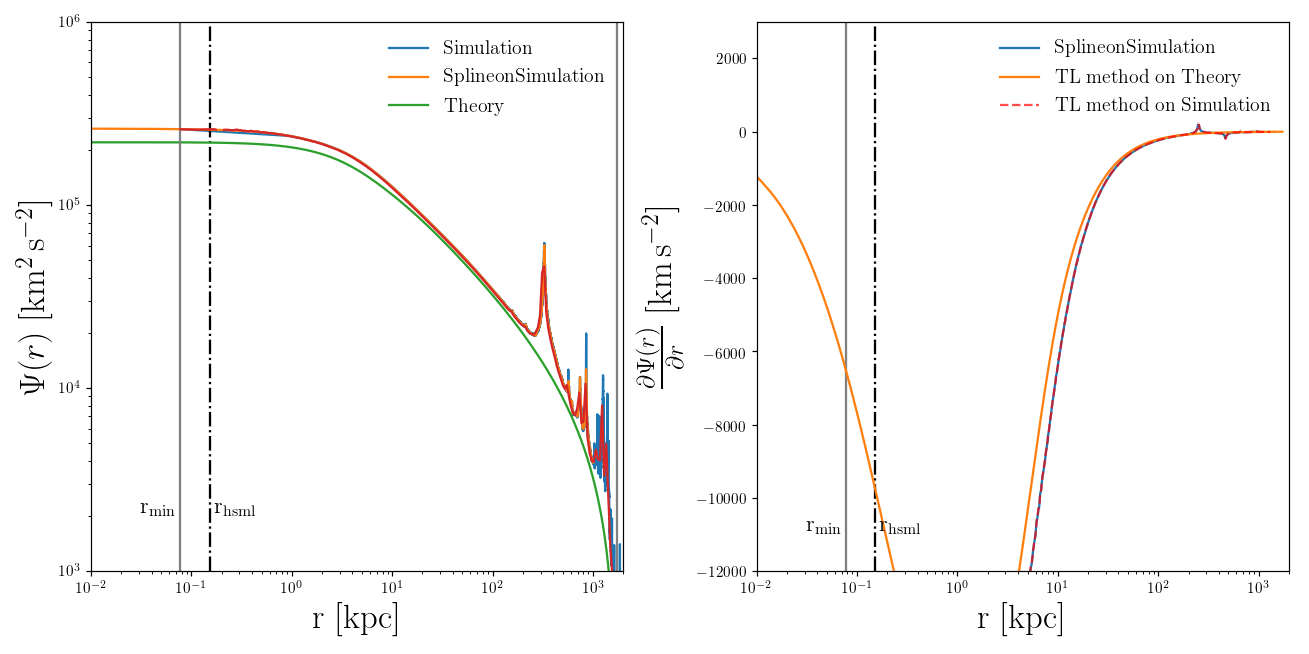

In [29]:
fig, [ax,ax1]= plt.subplots(1,2,figsize=[12,6])
ax.set_xscale('log')
ax.set_yscale('log')
ax1.set_xscale('log')
ax.set_xlabel(r'$\mathrm{r \;[kpc]}$', fontsize=23)
ax.set_ylabel(r'$\Psi(r)\mathrm{\;[km^2 \, s^{-2}]}$', fontsize=23)
ax.set_xlim([0.01,2000])
ax.set_ylim([1e3,1e6])
beg = 610
endo = 980

ax.plot(r_averaged, Psi_averaged,label=r"$\rm Simulation$")
#ax.scatter(r_sor,Psi_sor,s=4,c='gray', alpha=0.7)
ax.axvline(x=myhydro.gs.hsml.min(),c='k',ls='-.')
ax.text(1.1*myhydro.gs.hsml.min(),2e3,r'$\rm r_{hsml}$',fontsize=15)


ax.plot(r_sampled, spl(r_sampled),label=r"$\rm Spline on Simulation$")
ax.plot(Psi_r_the[:,0],Psi_r_the[:,1],label=r"$\rm Theory$")

leg = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=13)
leg.get_frame().set_linewidth(0.0)
ax.axvline(x=myhydro.dm.r.min(),c='gray',ls='-')
ax.text(0.4*myhydro.dm.r.min(),2e3,r'$\rm r_{min}$',fontsize=15)
ax.axvline(x=hydro.rmax,c='gray',ls='-')
ax.plot(r_log[:-1], Psi_av)

## second panel
ax1.set_xlim([0.01,2000])
ax1.set_ylim([-12e3,3e3])
ax1.axvline(x=myhydro.gs.hsml.min(),c='k',ls='-.')
ax1.text(1.1*myhydro.gs.hsml.min(),-11e3,r'$\rm r_{hsml}$',fontsize=15)
ax1.axvline(x=myhydro.dm.r.min(),c='gray',ls='-')
ax1.text(0.4*myhydro.dm.r.min(),-11e3,r'$\rm r_{min}$',fontsize=15)


G = myhydro.p.G*myhydro.p.kpctokm**3



ax1.plot(r_sampled,dfdx2,label=r"$\rm Spline on Simulation$")
r_plot = 10**np.linspace(np.log10(1e-3),np.log10(times*hydro.rmax),1000) #kpc    #don't go exactly to R_max, otherwise the interpolation may fail at the edge due to round-up numbers; it's not a problem

ax1.plot(r_plot, Psi_prime_num(r_plot),label=r"$\rm TL\;method\;on\;Theory$" )
r_plot = 10**np.linspace(np.log10(r_averaged[3]),np.log10(times*hydro.rmax),1000) #kpc    #don't go exactly to R_max, otherwise the interpolation may fail at the edge due to round-up numbers; it's not a problem

ax1.plot(r_plot, Psi_prime_num_S(r_plot),c='r',ls='--',alpha=0.7, label=r"$\rm TL\;method\;on\;Simulation$" )



ax1.set_xlabel('$\mathrm{r \;[kpc]}$', fontsize=23)
ax1.set_ylabel(r'$\frac{\partial\Psi(r)}{\partial r}\mathrm{\;[km\, s^{-2}]}$', fontsize=23)
plt.tight_layout()
leg = ax1.legend(loc='upper right', ncol=1, shadow=False, fontsize=13)
leg.get_frame().set_linewidth(0.0)
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/"+hydro.namenospace+"/Psi_n_PsiPrime"+hydro.namenospace+".pdf")

In [30]:
dPsidr_from_M =  - 1e17*myhydro.p.G* myhydro.p.kpctokm * m_cum / (r_sor)**2

In [31]:
print str(datetime.date.today())

2018-11-04


In [32]:
sorted_by_r = np.argsort(myhydro.dm.r)
r_sor = myhydro.dm.r[sorted_by_r]
v_sor = myhydro.dm.v[sorted_by_r]
cutted=10
#inside = np.where((r_sor>r_averaged[cutted])&(r_sor<r_averaged[-cutted]))
inside = np.where((r_sor>0.08)&(r_sor<hydro.rmax))

#making and equidistant array
part_per_bin = 3000
N_total = len(r_sor[inside])


##
dfdx_particle = derivative(spl,r_sor[inside],3e-1*r_sor[inside])
ep_sor = Psi_sor[inside] - (v_sor[inside]**2)/2.
ep_tmp = ep_sor[np.argsort(ep_sor)]
ep_tmp = ep_tmp[ep_tmp>0]
equi_bins = ep_tmp[range(0,len(ep_tmp),5000)]
bin_num = 200
bins = np.linspace(0,ep_sor.max(),bin_num)

w = -dfdx_particle/((4.*np.pi)**2) / (r_sor[inside]**2) / (v_sor[inside])
dNdE, E = np.histogram(ep_sor,bins=equi_bins,weights=w)
dNdE2, E2 = np.histogram(ep_sor,bins=bins,weights=w)

E_width = E[1:]-E[:-1]
E_center = (E[1:]+E[:-1])/2.

E_width2 = E2[1:]-E2[:-1]
E_center2 = (E2[1:]+E2[:-1])/2.

Psi_max_Sim = spl(r_sor[inside]).max()

In [33]:
sorted_by_r = np.argsort(myhydro.dm.r)
r_sor = myhydro.dm.r[sorted_by_r]
v_sor = myhydro.dm.v[sorted_by_r]

#inside = np.where((r_sor>r_averaged[cutted])&(r_sor<r_averaged[-cutted]))
#inside = np.where((r_sor>0.1)&(r_sor<hydro.rmax))

#making and equidistant array
part_per_bin = 1000
N_total = len(r_sor[inside])


##
dfdx_particle2 = Psi_prime_num(r_sor[inside])
ep_sor_the = Psi_interp(r_sor[inside]) - (v_sor[inside]**2)/2.
ep_tmp = ep_sor_the[np.argsort(ep_sor_the)]
ep_tmp = ep_tmp[ep_tmp>0]
equi_bins = ep_tmp[range(0,len(ep_tmp),5000)]
bin_num = 200
bins = np.linspace(0,ep_sor_the.max(),bin_num)

w_the = -dfdx_particle2 /((4.*np.pi)**2) / (r_sor[inside]**2) / (v_sor[inside])
dNdEE, E = np.histogram(ep_sor_the,bins=equi_bins,weights=w_the)
dNdEE2, E2 = np.histogram(ep_sor_the,bins=bins,weights=w_the)

EE_width = E[1:]-E[:-1]
EE_center = (E[1:]+E[:-1])/2.

EE_width2 = E2[1:]-E2[:-1]
EE_center2 = (E2[1:]+E2[:-1])/2.

Psi_max_theory = Psi_interp(r_sor[inside]).max()

<IPython.core.display.Javascript object>


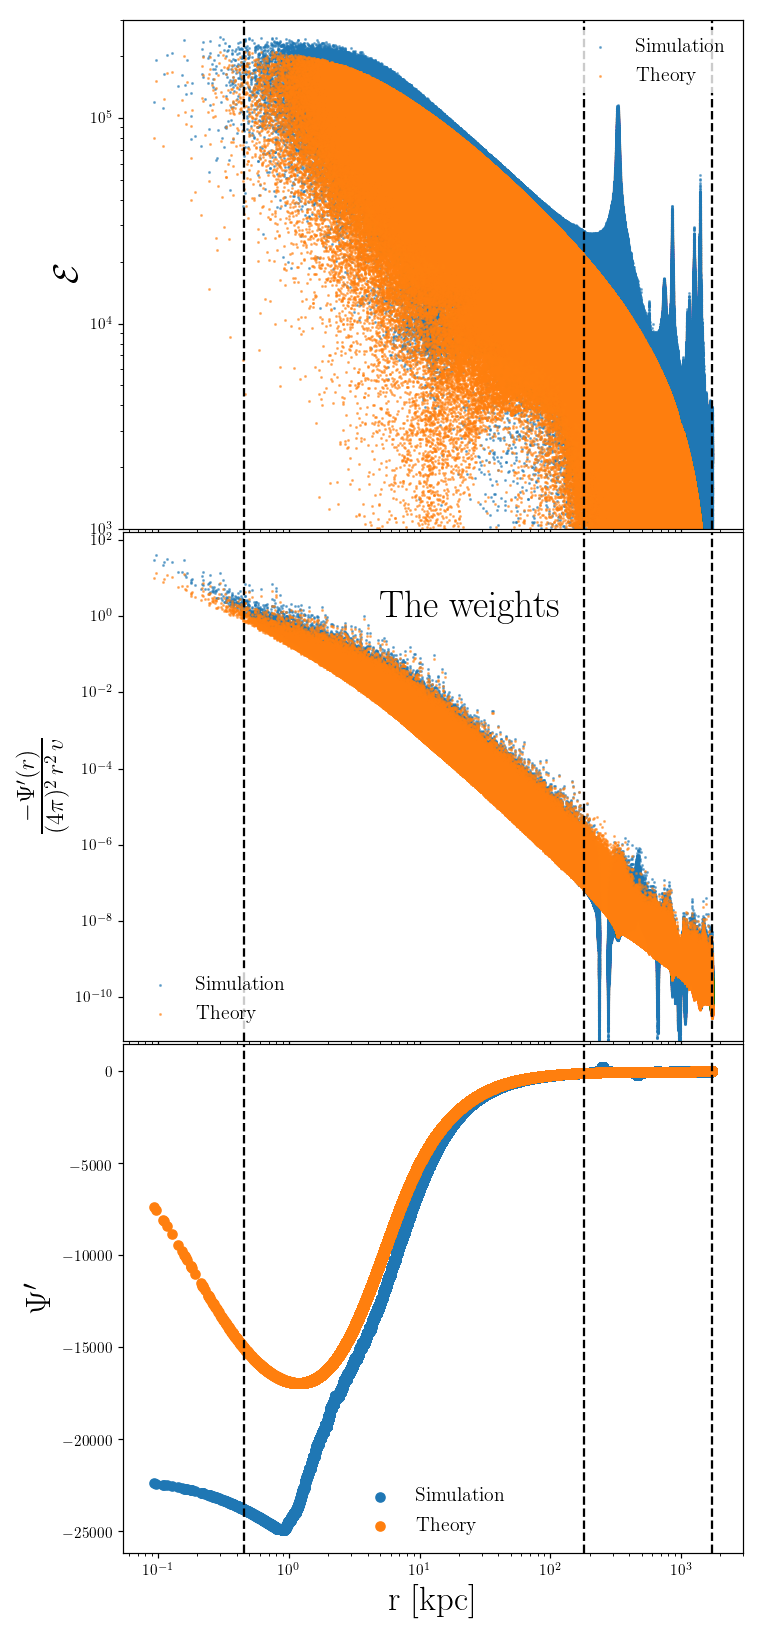

In [34]:

fig, [ax,ax1,ax2] = plt.subplots(3,1,sharex=True,figsize=[7,15])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e3,3e5)
#ax.set_xlabel(r'$\mathrm{r \;[kpc]}$', fontsize=23)
ax.set_ylabel(r'$\mathcal{E}$', fontsize=23)
ax.axvline(x=3*myhydro.gs.hsml.min(),c='k',ls='--')
ax.axvline(x=myhydro.r200,c='k',ls='--')
ax.axvline(x=hydro.rmax,c='k',ls='--')

fig.tight_layout()
ax.scatter(r_sor[inside],ep_sor,alpha=0.5,s=1,label= r"$\rm Simulation$")
ax.scatter(r_sor[inside],ep_sor_the,alpha=0.5,s=1,label= r"$\rm Theory$")
leg = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=13)

leg.get_frame().set_linewidth(0.0)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.axvline(x=3*myhydro.gs.hsml.min(),c='k',ls='--')
ax1.axvline(x=myhydro.r200,c='k',ls='--')
ax1.axvline(x=hydro.rmax,c='k',ls='--')
ax1.set_ylabel(r'$\frac{-\Psi^{\prime}(r)}{(4\pi)^2 \,r^2\, v}$', fontsize=23)
ax1.text(5,1,r"$\rm The \;weights$",fontsize=25)
fig.tight_layout()
ax1.scatter(r_sor[inside],w,alpha=0.5,s=1,label= r"$\rm Simulation$")
ax1.scatter(r_sor[inside],w_the,alpha=0.5,s=1,label= r"$\rm Theory$")
leg = ax1.legend(loc='lower left', ncol=1, shadow=False, fontsize=13)

leg.get_frame().set_linewidth(0.0)

ax2.set_xscale('log')
ax2.set_ylabel(r'$\Psi^{\prime}$', fontsize=23)
ax2.set_xlabel(r'$\mathrm{r \;[kpc]}$', fontsize=23)
ax2.axvline(x=3*myhydro.gs.hsml.min(),c='k',ls='--')
ax2.axvline(x=myhydro.r200,c='k',ls='--')
ax2.axvline(x=hydro.rmax,c='k',ls='--')
ax2.scatter(r_sor[inside], dfdx_particle,label= r"$\rm Simulation$")
ax2.scatter(r_sor[inside], dfdx_particle2,label= r"$\rm Theory$")
leg = ax2.legend(loc='lower rigt', ncol=1, shadow=False, fontsize=13)

leg.get_frame().set_linewidth(0.0)
fig.tight_layout(h_pad=-0.7)
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/"+hydro.namenospace+"/E_ingredients"+hydro.namenospace+".png")


<IPython.core.display.Javascript object>


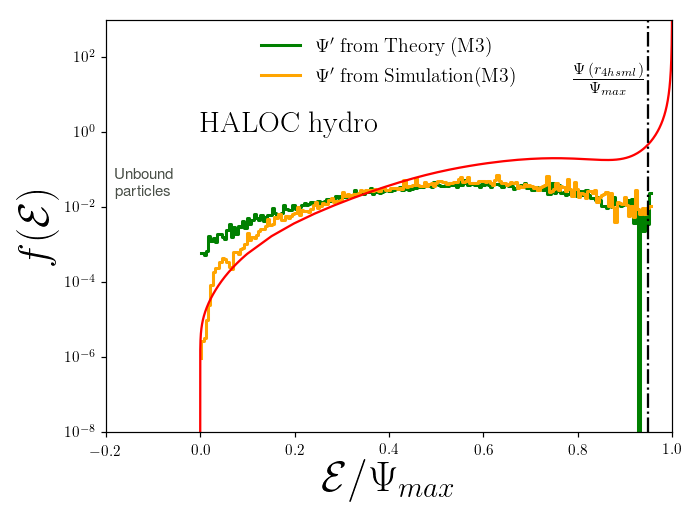

In [35]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$\mathcal{E}/ \Psi_{max}$',fontsize=28)
ax.set_ylabel(r'$f(\mathcal{E}) $',fontsize=28)
ax.set_ylim([1e-8,1e3])
ax.set_xlim([-0.2,1])
ax.set_yscale('log')
#ax.axvspan(xmin=-0.3,xmax=0,color='gray',alpha=0.5)

ax.step( EE_center2 / Psi_max_theory, dNdEE2/ EE_width2 ,linewidth=2,c='g',label=r"$\rm \Psi'\;from\;Theory\; (M3)$")

ax.step( E_center2 / Psi_max_Sim, dNdE2/ E_width2 ,linewidth=2,c='orange',label=r"$\rm  \Psi'\;from\;Simulation(M3)$")
ax.plot(f_E_Theory[:,0],f_E_Theory[:,1],'r')


#ax.scatter(E_tilde[unbounded]/Psi.max(), N_tilde[unbounded],label="Unbounded bins")
#ax.plot(ep_array_center/Psi.max(), mean_fE_bounded,'k--', label="mean of the unbounded data")
#ax.plot(ep_array_center/Psi.max(), mean_all,'k--', label=r"$\rm mean \;(M2)$")


ax.text(0.79,1e1,r"$\frac{\Psi\,(r_{4hsml})}{\Psi_{max}}$",fontsize=15)
#ax.axvline(x=resolutiont_limit_in_epsilon,color='k',linestyle='-.')
ax.axvline(x=resolutiont_limit_in_epsilonHSML,color='k',linestyle='-.')
ax.text(-0.18,2e-2,"Unbound\nparticles",color='#4b5149')
ax.text(0,1,r"$\rm "+hydro.namenospace+"\;"+hydro.version+"$", fontsize=20)

leg = ax.legend(loc='upper center', ncol=1, shadow=False, fontsize=13)

leg.get_frame().set_linewidth(0.0)
fig.tight_layout()
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/"+hydro.namenospace+"/Theory_vs_Sims"+hydro.namenospace+"_hydro.pdf")

<IPython.core.display.Javascript object>


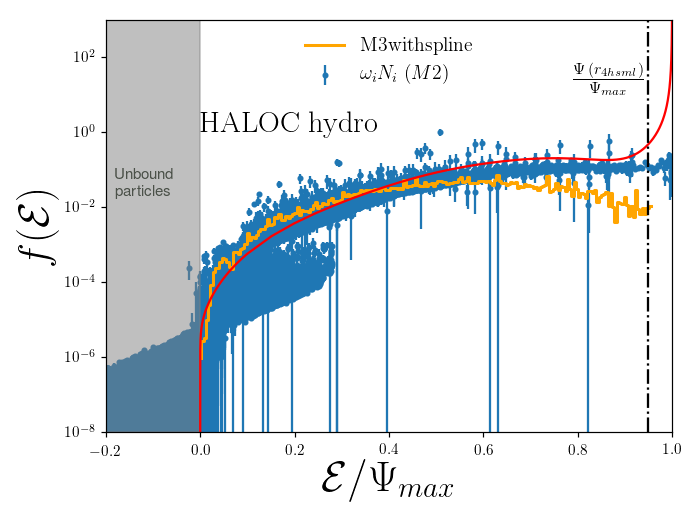

In [36]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$\mathcal{E}/ \Psi_{max}$',fontsize=28)
ax.set_ylabel(r'$f(\mathcal{E}) $',fontsize=28)
ax.set_ylim([1e-8,1e3])
ax.set_xlim([-0.2,1])
ax.set_yscale('log')
ax.axvspan(xmin=-0.3,xmax=0,color='gray',alpha=0.5)
ax.step( E_center2 /Psi_max_Sim,dNdE2/ E_width2 ,linewidth=2,c='orange',label=r"$\rm M3 with spline$")
ax.plot(f_E_Theory[:,0],f_E_Theory[:,1],'r')
ax.errorbar(xpoints/themaxofPsi, points, yerr=errpoints ,fmt='o',markersize=3,zorder=0,label=r"$\omega_i N_i\;(M2)$")


#ax.scatter(E_tilde[unbounded]/Psi.max(), N_tilde[unbounded],label="Unbounded bins")
#ax.plot(ep_array_center/Psi.max(), mean_fE_bounded,'k--', label="mean of the unbounded data")
#ax.plot(ep_array_center/Psi.max(), mean_all,'k--', label=r"$\rm mean \;(M2)$")


ax.text(0.79,1e1,r"$\frac{\Psi\,(r_{4hsml})}{\Psi_{max}}$",fontsize=15)
#ax.axvline(x=resolutiont_limit_in_epsilon,color='k',linestyle='-.')
ax.axvline(x=resolutiont_limit_in_epsilonHSML,color='k',linestyle='-.')
ax.text(-0.18,2e-2,"Unbound\nparticles",color='#4b5149')
ax.text(0,1,r"$\rm "+hydro.namenospace+"\;"+hydro.version+"$", fontsize=20)

leg = ax.legend(loc='upper center', ncol=1, shadow=False, fontsize=13)

leg.get_frame().set_linewidth(0.0)
fig.tight_layout()
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/"+hydro.namenospace+"/F_of_E_"+hydro.namenospace+"2Methods.pdf")

In [37]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$\mathcal{E}/ \Psi_{max}$',fontsize=28)
ax.set_ylabel(r'$f(\mathcal{E}) $',fontsize=28)
ax.set_ylim([1e-8,1e3])
ax.set_xlim([-0.2,1])
ax.set_yscale('log')
ax.axvspan(xmin=-0.3,xmax=0,color='gray',alpha=0.5)
ax.plot(f_E_Theory[:,0],f_E_Theory[:,1],'r')
ax.errorbar(xpoints/themaxofPsi, points, yerr=errpoints ,fmt='o',markersize=3,zorder=0,label=r"$\omega_i N_i\;(M2)$")


#ax.scatter(E_tilde[unbounded]/Psi.max(), N_tilde[unbounded],label="Unbounded bins")
#ax.plot(ep_array_center/Psi.max(), mean_fE_bounded,'k--', label="mean of the unbounded data")
#ax.plot(ep_array_center/Psi.max(), mean_all,'k--', label=r"$\rm mean \;(M2)$")


ax.text(0.79,1e1,r"$\frac{\Psi\,(r_{4hsml})}{\Psi_{max}}$",fontsize=15)
#ax.axvline(x=resolutiont_limit_in_epsilon,color='k',linestyle='-.')
ax.axvline(x=resolutiont_limit_in_epsilonHSML,color='k',linestyle='-.')
ax.text(-0.18,2e-2,"Unbound\nparticles",color='#4b5149')
ax.text(0,1e1,r"$\rm "+hydro.namenospace+"\;"+hydro.version+"$", fontsize=20)
leg = ax.legend(loc='upper center', ncol=1, shadow=False, fontsize=13)

leg.get_frame().set_linewidth(0.0)
fig.tight_layout()
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/"+hydro.namenospace+"/F_of_E_"+hydro.namenospace+".pdf")

<IPython.core.display.Javascript object>

In [38]:
Psi_prime_all = Psi_prime_Spline(myhydro.dm.r)

In [39]:

Psi_all = (maxval - Phy[:len(myhydro.dm.mass)]) / myhydro.dm.mass
#Psi_all = (hydro.pot_max - Phy[:len(myhydro.dm.mass)]) / myhydro.dm.mass
Epsilon_all = Psi_all - (myhydro.dm.v**2)/2.
#Nomed_Eps = Epsilon_all / (myhydro.dm.r**2) / (myhydro.dm.v**2) / 16 / np.pi**2 / N_total
weights = -Psi_prime_all / (myhydro.dm.r**2) / (myhydro.dm.v) / 16 / np.pi**2 

Epsilon_sor = Epsilon_all[np.argsort(Epsilon_all)]
bins_epsilon = Epsilon_sor[np.linspace(0,len(Epsilon_sor)-1,20,dtype=int)]
bin_num = 40
dN_deps, bins_eps =np.histogram(Epsilon_all,bins=bin_num,weights=weights)
counts, bins_eps =np.histogram(Epsilon_all,bins=bin_num)
deltaeps = bins_eps[1:]-bins_eps[:-1]
d2N_deps2 = (dN_deps[1:]-dN_deps[:-1])/deltaeps[1:]
d2N_deps2_40, bins_eps_40 = d2N_deps2, bins_eps
bin_num = 20
dN_deps, bins_eps =np.histogram(Epsilon_all,bins=bin_num,weights=weights)
counts, bins_eps =np.histogram(Epsilon_all,bins=bin_num)
deltaeps = bins_eps[1:]-bins_eps[:-1]
d2N_deps2 = (dN_deps[1:]-dN_deps[:-1])/deltaeps[1:]
d2N_deps2_20, bins_eps_20 = d2N_deps2, bins_eps
bin_num = 50
dN_deps, bins_eps =np.histogram(Epsilon_all,bins=bin_num,weights=weights)
counts, bins_eps =np.histogram(Epsilon_all,bins=bin_num)
deltaeps = bins_eps[1:]-bins_eps[:-1]
d2N_deps2 = (dN_deps[1:]-dN_deps[:-1])/deltaeps[1:]
d2N_deps2_60, bins_eps_60 = d2N_deps2, bins_eps

<IPython.core.display.Javascript object>


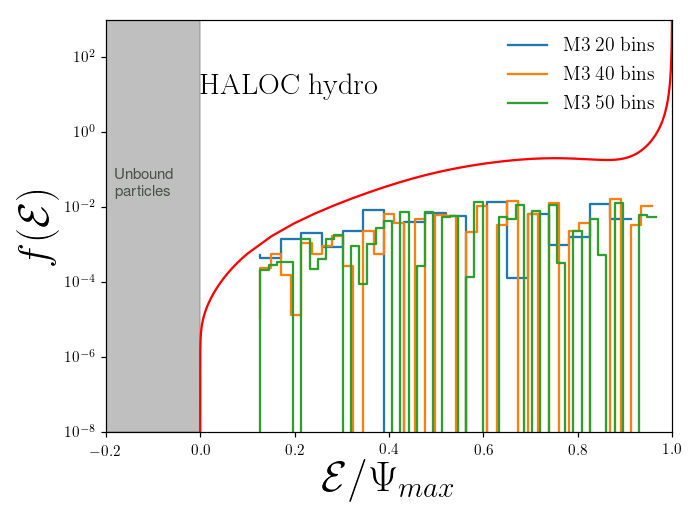

In [41]:

fig, ax = plt.subplots()
ax.set_xlabel(r'$\mathcal{E}/ \Psi_{max}$',fontsize=28)
ax.set_ylabel(r'$f(\mathcal{E}) $',fontsize=28)
ax.set_ylim([1e-8,1e3])
ax.set_xlim([-0.2,1])
ax.set_yscale('log')
ax.axvspan(xmin=-0.3,xmax=0,color='gray',alpha=0.5)
ax.step(1+bins_eps_20[:-2]/Psi.max(),d2N_deps2_20, label=r'$\rm M3\;20\;bins$' )
ax.step(1+bins_eps_40[:-2]/Psi.max(),d2N_deps2_40,label=r'$\rm M3\;40\;bins$')
ax.step(1+bins_eps_60[:-2]/Psi.max(),d2N_deps2_60, label=r'$\rm M3\;50\;bins$' )
ax.text(-0.18,2e-2,"Unbound\nparticles",color='#4b5149')
ax.text(0,1e1,r"$\rm "+hydro.namenospace+"\;"+hydro.version+"$", fontsize=20)
leg = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=13)

leg.get_frame().set_linewidth(0.0)
fig.tight_layout()


ax.plot(f_E_Theory[:,0],f_E_Theory[:,1],'r')
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/"+hydro.namenospace+"/F_of_E_Method3"+hydro.namenospace+".pdf")

# DMO

In [42]:

myDMO = wkbl.Galaxy_Hound(dmo.path)
print myDMO.dm.pos3d[:,0].max()
zoomreg = np.where(myDMO.dm.mass==myDMO.dm.mass.min())
centro = nbe.real_center(myDMO.dm.pos3d[zoomreg],myDMO.dm.mass[zoomreg])

myDMO.center_shift(dmo.c_dm_pot)
#myDMO.center_shift(dmo.c_dm_com)

myDMO.r_virial(600,n=25)
myDMO.r200
ration = 1.6*dmo.rmax/myDMO.r200
myDMO.redefine(ration)


loading Dark matter..
19878.01


In [43]:
print "{0:.2e}".format(myDMO.dm.total_m)

7.33e+11


In [44]:
pos = np.array(myDMO.dm.pos3d.reshape(len(myDMO.dm.pos3d)*3),dtype=np.float32)
phi_cord =myDMO.dm.phi

mass = myDMO.dm.mass
v = myDMO.dm.v
print len(mass)*3, len(pos)
r2 = myDMO.dm.pos3d[:,0]**2 + myDMO.dm.pos3d[:,1]**2 +myDMO.dm.pos3d[:,2]**2

26919102 26919102


In [45]:
print myDMO.dm.r.max()

3617.0063058746005


In [46]:
ok, acc, Phy = CF.getGravity(pos,mass,0.15,G=myDMO.p.G)
Phy = Phy * myDMO.p.kpctokm**2


In [47]:
poto =  myDMO.dm.pos3d[Phy==Phy.min()][0]
dmo.c_dm_com+poto

array([9861.9777 , 9776.37011, 9790.41548])

In [48]:
ok,myDMO.dm.rho,_= CF.getDensity(np.array(myDMO.dm.pos3d.reshape(len(myDMO.dm.pos3d)*3),dtype=np.float32), myDMO.dm.mass)


In [49]:
fig, ax = plt.subplots()
ax.scatter(myDMO.dm.r[myDMO.dm.r<6], Phy[myDMO.dm.r<6])

<IPython.core.display.Javascript object>

In [50]:
def binning_a_bel(minimum,mean,maximum,bins):
    "most efficient way of binning a bell curve"
    a = np.logspace(np.log10(0.15*maximum),np.log10(maximum-mean),bins/2)
    b = np.logspace(np.log10(0.15*maximum),np.log10(mean-minimum),bins/2)
    second_part = mean+ a - a[0]
    first_part = (mean-b+b[0])[::-1]
    return np.concatenate([[minimum],first_part, second_part[1:],[maximum]])

In [51]:
%%latex
\begin{equation}
\Psi(r) = \Phi(r)_0-\Phi(r)
\end{equation}
\begin{equation}
\mathcal{E} = \Phi(r)- \frac{v^2}{2}
\end{equation}


<IPython.core.display.Latex object>

In [52]:
%%latex
We first define equipopulated bins in r, with enough particles to effectively sample the velocity distribution in each bin, $n_{bin} \sim 15000 - 30000 $
. We then build the vdf in each bin in r with 100 bins in v from 0 to the local $v_{max}$. 

<IPython.core.display.Latex object>

In [53]:
Pcrit = myDMO.dm._p.rho_crit
Mdm = myDMO.dm.mass.min()
myradiuses = myDMO.dm.r[np.argsort(myDMO.dm.r)]
tabN = np.cumsum(np.ones(len(myradiuses)))[1:]
myradiuses = myradiuses[1:]
Rp03 = np.sqrt(200/64.) * np.sqrt(4 * np.pi * Pcrit * tabN / 3. / Mdm ) * (myradiuses**1.5)/ np.log(tabN) 
val =0.6
R_P03 = myradiuses[ np.where(Rp03 > val) ][0]
print "Power03 radius for "+dmo.name+" is of {0:.3f} kpc ".format(R_P03)

Power03 radius for Halo C is of 1.080 kpc 


In [54]:
endR = dmo.rmax
in_halo = np.where((myDMO.dm.r>1.)&(myDMO.dm.r<endR))#&((myDMO.dm.r>2.*myDMO.gs.hsml)))
sorted_r = np.argsort(myDMO.dm.r[in_halo])
part_per_bin = 15000
N_total = len(myDMO.dm.mass[in_halo])

bins_index = sorted_r[np.linspace(0,N_total-1,N_total/part_per_bin,dtype=int)]
bins_in_r = (myDMO.dm.r[in_halo])[bins_index]


In [55]:
#first bin in r
#binnum_r=100
#bins_in_r = np.logspace(np.log10(3.*myDMO.gs.hsml.min()),np.log10(myDMO.r200),binnum_r)
#bins_in_r = np.concatenate([[0],bins_in_r])
bins_centers = (bins_in_r[1:]+bins_in_r[:-1])/2.
bins_width = (bins_in_r[1:]-bins_in_r[:-1])

length_v = 100
#bin_master_array = np.vstack([np.ones(length_v+1)])
#hist_master_array = np.vstack([np.ones(length_v)])
phi_r = np.array([])
selection = np.where((myDMO.dm.r>R_P03)&(myDMO.dm.r>bins_in_r[0])&(myDMO.dm.r<bins_in_r[1]))
phi_r = np.append(phi_r,np.mean(Phy[selection]))
my_Vs = myDMO.dm.v[selection]
my_rs = myDMO.dm.r[selection]
r_width = bins_in_r[1]-bins_in_r[0]
bins_in_v = np.linspace(my_Vs.min(),my_Vs.max(),length_v+1)#binning_a_bel(my_Vs.min(),np.mean(my_Vs),my_Vs.max(),length_v)
bins_in_v_centers = (bins_in_v[1:] +bins_in_v[:-1])/2
bins_in_v_width = (bins_in_v[1:] - bins_in_v[:-1])
bin_master_array = np.vstack([bins_in_v])
bin_master_centers = np.vstack([bins_in_v_centers])
bin_master_width = np.vstack([bins_in_v_width])
bin_master_width2 = np.vstack([r_width*bins_in_v_width])

f_v, _ = np.histogram(my_Vs,bins=bins_in_v)
f_v_method2, _ = np.histogram(my_Vs,bins=bins_in_v, weights=1./((4*np.pi*my_Vs*my_rs)**2))

hist_master_array = np.vstack([f_v])
hist_master_array_method2 = np.vstack([f_v_method2])
mass_in, _ = np.histogram(my_Vs,bins=bins_in_v,weights=myDMO.dm.mass[selection])
mass_master_array = np.vstack([mass_in])
# iterates over r bins
for i in range(1,len(bins_in_r)-1):
    #defindes the shell
    selection = np.where((myDMO.dm.r>R_P03)&(myDMO.dm.r>bins_in_r[i])&(myDMO.dm.r<=bins_in_r[i+1]))
    r_width = bins_in_r[i+1]-bins_in_r[i]
    phi_r = np.append(phi_r,np.mean(Phy[selection]))# potential
    my_Vs = myDMO.dm.v[selection]# speed
    my_rs = myDMO.dm.r[selection]# speed
    bins_in_v =np.linspace(my_Vs.min(),my_Vs.max(),length_v+1)# binning of the vdf in the shell
    bins_in_v_centers = (bins_in_v[1:] +bins_in_v[:-1])/2
    bins_in_v_width = (bins_in_v[1:] - bins_in_v[:-1])
    # useful 2d arrays with bins info
    bin_master_array = np.vstack([bin_master_array,bins_in_v]) # 2darray of bins edges
    bin_master_centers = np.vstack([bin_master_centers,bins_in_v_centers]) # bins centers
    bin_master_width = np.vstack([bin_master_width,bins_in_v_width]) # bins v width
    bin_master_width2 = np.vstack([bin_master_width2,r_width*bins_in_v_width]) # Delta r* Delta v
    # fdv for the shell
    f_v, _ = np.histogram(my_Vs,bins=bins_in_v)
  
    f_v_method2, _ = np.histogram(my_Vs,bins=bins_in_v, weights=1./((4*np.pi*my_Vs*my_rs)**2))

    hist_master_array = np.vstack([hist_master_array, f_v])

    hist_master_array_method2 = np.vstack([hist_master_array_method2, f_v_method2])
    mass_in, _ = np.histogram(my_Vs,bins=bins_in_v,weights=myDMO.dm.mass[selection])
    mass_master_array = np.vstack([mass_in])
    

In [56]:

# vesc
r_4_pot = np.linspace(1, dmo.rmax,200)
pot_r, r_4_pot = np.histogram(myDMO.dm.r,bins = r_4_pot, weights=Phy[:len(myDMO.dm.r)])
pot_r2, r_4_pot = np.histogram(myDMO.dm.r,bins = r_4_pot, weights=Phy[:len(myDMO.dm.r)]**2)

n_pot_r, r_4_pot = np.histogram(myDMO.dm.r,bins = r_4_pot)
pot_r /= n_pot_r
pot_r2 /= n_pot_r
std_vesc = pot_r2 - (pot_r)**2 
vesc_r = np.sqrt(2*(Phy.max()-pot_r))
f_vesc_r = interp1d((r_4_pot[1:]+r_4_pot[:-1])/2., vesc_r)
f_vesc_std = interp1d(((r_4_pot[1:]+r_4_pot[:-1])/2.)[std_vesc>0], np.sqrt(std_vesc[std_vesc>0]))

<IPython.core.display.Javascript object>


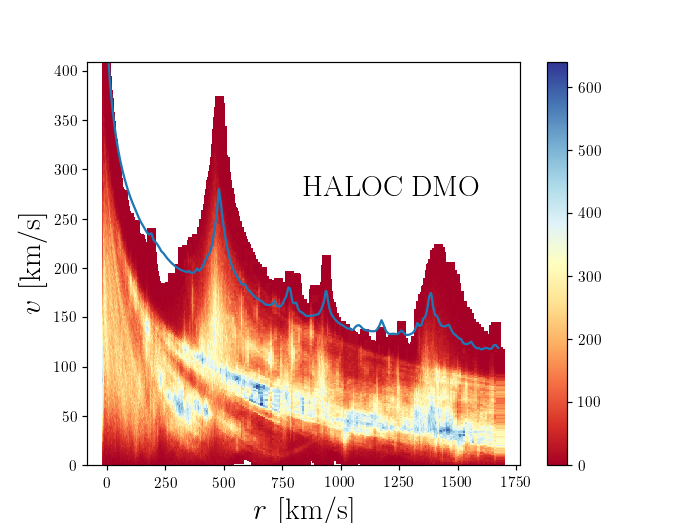

low =  3
upp =  -1
(461, 100)
(461, 100)


Text(841.754,272.442,'$\\rm HALOC\\;DMO$')

In [57]:
fig, ax = plt.subplots()
cmap = plt.cm.get_cmap('RdYlBu')
ax.set_xlabel(r"$ r \,\,\textrm{[km/s]}$",fontsize=20 )
ax.set_ylabel(r"$ v \,\,\textrm{[km/s]}$",fontsize=20)
#ax.set_xlim(0,myDMO.r200)
ax.set_ylim(0,bin_master_array.max())
R = np.zeros(bin_master_centers.shape)
R_w = np.zeros(bin_master_width.shape)

bins_in_r_center = (bins_in_r[1:]+bins_in_r[:-1])/2
bins_in_r_width = (bins_in_r[1:]-bins_in_r[:-1])

R[:,:] = np.vstack(bins_in_r_center)
R_w[:,:] = np.vstack( bins_in_r_width )


#define range
done=False
# lower limit
low = 0
while  done==False:
    try:
        f_vesc_r(bins_in_r_center[low])
        done=True
    except:
        low+=1
print "low = ",low
done=False
# upper limit
upp = -1
while done==False:
    try:
        f_vesc_r(bins_in_r_center[upp])
        done=True
    except:
        upp-=1
print "upp = ", upp


print R.shape
B = bin_master_centers
print B.shape
COLOR = hist_master_array.reshape(1,len(hist_master_array)*len(hist_master_array[0]))
normalize = mpl.colors.Normalize(vmin=np.nanmin(COLOR[0]), vmax=np.nanmax(COLOR[0]))
colors = [cmap(normalize(value)) for value in np.nan_to_num(COLOR[0])]
sc = ax.scatter( R.reshape(1,len(R)*len(R[0])),B.reshape(1,len(B)*len(B[0])),marker='s',lw=0,c=colors)
cax, _ = mpl.colorbar.make_axes(ax)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
ax.plot(bins_in_r_center[low:upp],f_vesc_r(bins_in_r_center[low:upp]))
ax.plot(bins_in_r_center[low:upp],f_vesc_r(bins_in_r_center[low:upp])- f_vesc_std(bins_in_r_center[low:upp]))

ax.text(bins_in_r_center.max()/2,2*bin_master_array.max()/3,r"$\rm "+dmo.namenospace+"\;"+dmo.version+"$", fontsize=20)

In [58]:
print Phy.max()
diffe = .2
con = np.where((myDMO.dm.r > (1-diffe)*dmo.rmax)&(myDMO.dm.r < (1+diffe)*dmo.rmax))
maxval = np.mean(Phy[con])
print maxval

-7124.659
-15725.671


In [59]:

pot_path = "/home/arturo/Documents/LAM/LAM2LUPM/f_of_E/"+dmo.namenospace+"/fE_Eddington_"
theory_file_path = glob.glob(pot_path+dmo.namenospace+"_DMO*")
print theory_file_path
f_E_Theory = np.loadtxt(theory_file_path[0])

['/home/arturo/Documents/LAM/LAM2LUPM/f_of_E/HALOC/fE_Eddington_HALOC_DMO_Rmax=1688.46kpc_no_divergence.txt']


In [60]:
Psi = maxval - phi_r
themaxofPsiDMO = Psi.max()
P = np.zeros(bin_master_centers.shape)
P[:,:] = np.vstack(Psi)
Epsilon = P  -  (bin_master_centers**2) /2.

#N_bins = hist_master_array/R**2 / bin_master_centers**2 /16./ np.pi**2 / N_total / bin_master_width / R_w
N_bins_original = myDMO.dm.mass.min() * hist_master_array / R**2 / bin_master_centers**2 /16./ np.pi**2  / bin_master_width / R_w
###
### second chance
volshel = (4./3.)*np.pi*(bins_in_r[1:]**3-bins_in_r[:-1]**3)
VOL = np.zeros(bin_master_centers.shape)
VOL[:,:] = np.vstack(volshel)
N_bins = myDMO.dm.mass.min() * hist_master_array / bin_master_centers**2 /4./ np.pi  / bin_master_width / VOL
DN_bins = myDMO.dm.mass.min() * np.sqrt(hist_master_array) / bin_master_centers**2 /4./ np.pi  / bin_master_width / VOL

N_bins_method2 = myDMO.dm.mass.min() * hist_master_array_method2 / bin_master_width2


In [61]:
N_bins_method2.max()

37.83309407233859

In [62]:
print Phy.max(), dmo.pot_max

-7124.659 -20588.9


In [63]:
# one bin one  point
epsilon_1d = Epsilon.reshape(1,len(Epsilon)*len(Epsilon[0]))
f_E_1d = N_bins.reshape(1,len(N_bins)*len(N_bins[0]))

In [64]:

bins_epsilon = np.linspace(Epsilon.min(), Epsilon.max(),40)
bins_epsilon_center = (bins_epsilon[1:]+bins_epsilon[:-1])/2.
mean_bin_M2 = f_E = f_E_method2 = np.array([])
for i in range(0,len(bins_epsilon)-1):
    in_bin = np.where((Epsilon>=bins_epsilon[i])&(Epsilon<bins_epsilon[i+1]))
    f_E_o = np.append(f_E,np.sum(N_bins_original[in_bin]))
    f_E = np.append(f_E,np.sum(N_bins[in_bin]))
    mean_bin_M2 = np.append(mean_bin_M2,np.mean(N_bins_method2[in_bin]))
    f_E_method2 = np.append(f_E_method2,np.sum(N_bins_method2[in_bin]))

In [65]:
Psi_all = (maxval - Phy[:len(myDMO.dm.mass)]) / myDMO.dm.mass
Epsilon_all = Psi_all - (myDMO.dm.v**2)/2.
#Nomed_Eps = Epsilon_all / (myDMO.dm.r**2) / (myDMO.dm.v**2) / 16 / np.pi**2 / N_total
weights = 1. / (myDMO.dm.r**2) / (myDMO.dm.v**2) / 16 / np.pi**2 /N_total
new_in_halo = np.where((myDMO.dm.r>2*0.281)&(myDMO.dm.r<myDMO.r200))
f_E_all, _ =np.histogram(Epsilon_all[new_in_halo],bins=bins_epsilon, weights=weights[new_in_halo])

In [66]:
res_lim = (r2>(R_P03)**2)&(r2<(1.1*R_P03)**2)

resolutiont_limit_in_epsilon = (Phy.max()-np.mean(Phy[res_lim])-(np.mean(v[res_lim])**2)/2.)/Psi.max()
resolutiont_limit_in_epsilon = (Phy.max()-np.mean(Phy[res_lim]))/Psi.max()
print resolutiont_limit_in_epsilon

1.125507444375597


In [67]:
#x_100_100, F_E_100_100 = bins_epsilon_center/Psi.max(),f_E
#x_100_200, F_E_100_200 = bins_epsilon_center/Psi.max(),f_E
#x_100_300, F_E_100_300 = bins_epsilon_center/Psi.max(),f_E
#x_100_400, F_E_100_400 = bins_epsilon_center/Psi.max(),f_E
#x_100_eq2e4, F_E_100_eq2e4 = bins_epsilon_center/Psi.max(),f_E
#x_30_eq1e4, F_E_30_eq1e4 = bins_epsilon_center/Psi.max(),f_E

In [68]:
ep_array = np.linspace(Epsilon.min(), Epsilon.max(), 40)
sum_bin_M1,bins = np.histogram(Epsilon, bins=ep_array,weights=N_bins)
num_bin_M1,bins = np.histogram(Epsilon, bins=ep_array)
mean_bin_M1  = sum_bin_M1 / num_bin_M1
center_mean = (bins[1:]+bins[:-1])/2.


In [69]:
print R.shape, bin_master_centers.shape

(461, 100) (461, 100)


In [70]:
lowL = 5
superR = R[R>=lowL]
superV = bin_master_centers[R>=lowL]
E_tilde = Epsilon[R>=lowL]
N_tilde = N_bins[R>=lowL]
R_tilde = R[R>=lowL]


In [71]:
mean_all =  delta_all =delta_all2 =mean_fE_bounded = std_fE_bounded = mean_fE_unbounded = std_fE_unbounded = np.array([])
ep_array_center = (ep_array[1:]+ep_array[:-1])/2.
for i in range(len(ep_array)-1):
    ep_cut = (Epsilon>ep_array[i])&(Epsilon<ep_array[i+1])
    mean_all = np.append(mean_all, np.mean(N_bins[ep_cut]))
    delta_all = np.append(delta_all,np.mean(DN_bins[ep_cut]))
    delta_all2 = np.append(delta_all2,np.mean(np.sqrt(N_bins[ep_cut])))

    
    

In [72]:
xpoints = Epsilon.reshape(1,len(Epsilon)*len(Epsilon[0]))
points = N_bins_method2.reshape(1,len(N_bins)*len(N_bins[0]))
colors = R.reshape(1,len(R)*len(R[0]))

errpoints = DN_bins.reshape(1,len(DN_bins)*len(DN_bins[0]))


In [73]:
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

<IPython.core.display.Javascript object>


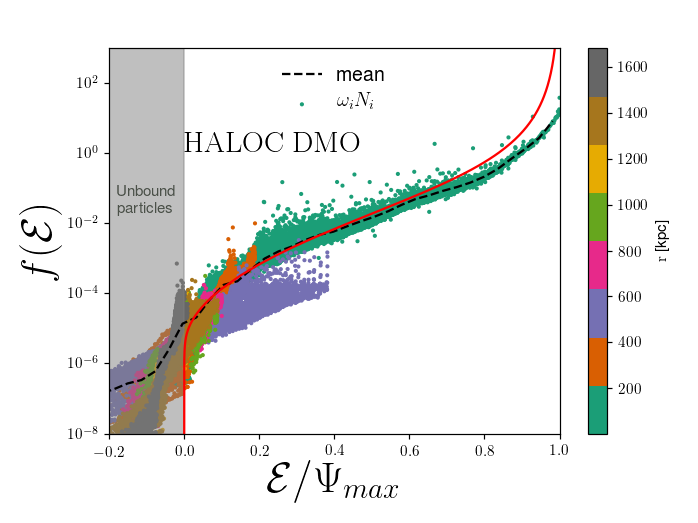

In [74]:

fig, ax = plt.subplots()
fig.tight_layout(rect=[0.09, 0.09, 1, 0.95])
cmap = plt.cm.get_cmap('Dark2')
ax.set_xlabel(r'$\mathcal{E}/ \Psi_{max}$',fontsize=28)
ax.set_ylabel(r'$f(\mathcal{E}) $',fontsize=28)
ax.set_ylim([1e-8,1e3])
ax.set_xlim([-0.2,1])
ax.set_yscale('log')
ax.axvspan(xmin=-0.3,xmax=0,color='gray',alpha=0.5)


#ax.scatter(Epsilon/Psi.max()+2000, N_bins,label=r"$\omega_i N_i$")
normalize = mpl.colors.Normalize(vmin=np.nanmin(colors[0]), vmax=np.nanmax(colors[0]))
mapa = [cmap(normalize(value)) for value in np.nan_to_num(colors[0])]
#ax.errorbar(xpoints/Psi.max(), points, yerr=errpoints ,fmt='o',markersize=3,zorder=0,c=cmap(norm(colors[0])),label=r"$\omega_i N_i$")
sc = ax.scatter(xpoints/themaxofPsiDMO, points, s=3,zorder=0,c=mapa,label=r"$\omega_i N_i$")
cax, _ = mpl.colorbar.make_axes(ax)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize,label=r"$\rm r$ [kpc]")

#ax.scatter(E_tilde[unbounded]/Psi.max(), N_tilde[unbounded],label="Unbounded bins")
#ax.plot(ep_array_center/Psi.max(), mean_fE_bounded,'k--', label="mean of the unbounded data")
ax.plot(ep_array_center/Psi.max(), mean_all,'k--', label="mean")

#diff = np.abs(r_averaged- R_P03)
#res_lim =Psi_averaged[(diff == diff.min()) ][0]/ Psi_averaged.max()
#ax.axvline(x=res_lim,c='k',ls='-.')
ax.text(-0.18,2e-2,"Unbound\nparticles",color='#4b5149')
ax.text(0,1,r"$\rm "+dmo.namenospace+"\;"+dmo.version+"$", fontsize=20)

leg = ax.legend(loc='upper center', ncol=1, shadow=False, fontsize=13)

leg.get_frame().set_linewidth(0.0)

ax.plot(f_E_Theory[:,0],f_E_Theory[:,1],'r')
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/"+dmo.namenospace+"/F_of_E_"+dmo.namenospace+"DMO.pdf")

<IPython.core.display.Javascript object>


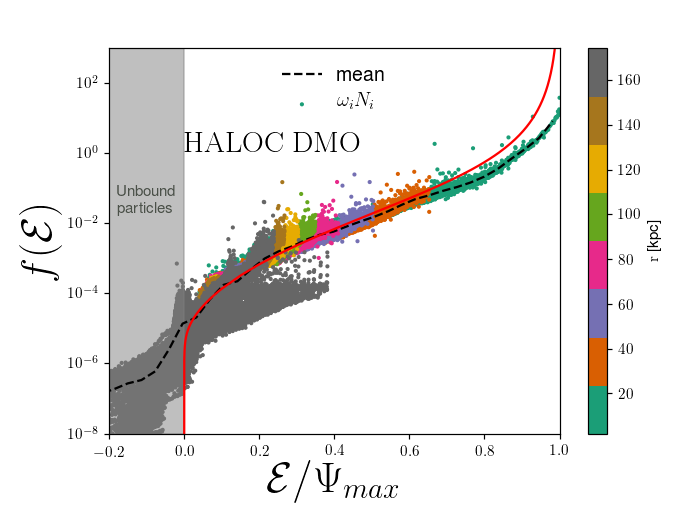

In [75]:


fig, ax = plt.subplots()
fig.tight_layout(rect=[0.09, 0.09, 1, 0.95])
cmap = plt.cm.get_cmap('Dark2')
ax.set_xlabel(r'$\mathcal{E}/ \Psi_{max}$',fontsize=28)
ax.set_ylabel(r'$f(\mathcal{E}) $',fontsize=28)
ax.set_ylim([1e-8,1e3])
ax.set_xlim([-0.2,1])
ax.set_yscale('log')
ax.axvspan(xmin=-0.3,xmax=0,color='gray',alpha=0.5)


#ax.scatter(Epsilon/Psi.max()+2000, N_bins,label=r"$\omega_i N_i$")
max_vir = np.nanmax(colors[colors<myDMO.r200])
normalize = mpl.colors.Normalize(vmin=np.nanmin(colors[0]), vmax=max_vir)
mapa = [cmap(normalize(value)) for value in np.nan_to_num(colors[0])]
#ax.errorbar(xpoints/Psi.max(), points, yerr=errpoints ,fmt='o',markersize=3,zorder=0,c=cmap(norm(colors[0])),label=r"$\omega_i N_i$")
sc = ax.scatter(xpoints/themaxofPsiDMO, points, s=3,zorder=0,c=mapa,label=r"$\omega_i N_i$")
cax, _ = mpl.colorbar.make_axes(ax)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize,label=r"$\rm r$ [kpc]")

#ax.scatter(E_tilde[unbounded]/Psi.max(), N_tilde[unbounded],label="Unbounded bins")
#ax.plot(ep_array_center/Psi.max(), mean_fE_bounded,'k--', label="mean of the unbounded data")
ax.plot(ep_array_center/Psi.max(), mean_all,'k--', label="mean")

#diff = np.abs(r_averaged- R_P03)
#res_lim =Psi_averaged[(diff == diff.min()) ][0]/ Psi_averaged.max()
#ax.axvline(x=res_lim,c='k',ls='-.')
ax.text(-0.18,2e-2,"Unbound\nparticles",color='#4b5149')
ax.text(0,1,r"$\rm "+dmo.namenospace+"\;"+dmo.version+"$", fontsize=20)

leg = ax.legend(loc='upper center', ncol=1, shadow=False, fontsize=13)

leg.get_frame().set_linewidth(0.0)

ax.plot(f_E_Theory[:,0],f_E_Theory[:,1],'r')
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/"+dmo.namenospace+"/F_of_E_"+dmo.namenospace+"DMO_r200.pdf")

In [76]:
%%time
sorted_by_r = np.argsort(myDMO.dm.r)
r_sor = myDMO.dm.r[sorted_by_r]
v_sor = myDMO.dm.v[sorted_by_r]

Phi = Phy
Psi_sor = maxval-Phi[sorted_by_r]
window_size = 3000
block_size =200
mow_Psi= Psi_sor[:window_size]
mow_r = r_sor[:window_size]
print np.mean(mow_r)
Psi_averaged = np.array([])#Psi_sor[0]])
r_averaged = np.array([])#r_sor[0])
for i in range(15,len(Psi_sor)/block_size):
    to=i%(window_size/block_size)
    Psi_averaged = np.append(Psi_averaged, np.mean(mow_Psi))
    r_averaged = np.append(r_averaged, np.mean(mow_r))
    mow_Psi[to*block_size:block_size*(to+1)] = Psi_sor[i*block_size:block_size*(i+1)]
    mow_r[to*block_size:block_size*(to+1)] = r_sor[i*block_size:block_size*(i+1)]   

0.7638020659387724
CPU times: user 4.08 s, sys: 108 ms, total: 4.18 s
Wall time: 4.18 s


In [90]:
r_sor = myDMO.dm.r[sorted_by_r]
r_log = np.array([myDMO.dm.r.min(),r_sor[5]])
r_log = np.concatenate([r_log, np.logspace(np.log10(r_sor[12]), np.log10(1.2*dmo.rmax),200)])
r_center = (r_log[1:]+r_log[:-1])/2
Psi = maxval - Phy
psi,_ = np.histogram(myDMO.dm.r, bins=r_log, weights=Psi)
phi,_ = np.histogram(myDMO.dm.r, bins=r_log, weights=Phy)
n,_ = np.histogram(myDMO.dm.r, bins=r_log)
Psi_av = psi/n
Phi_av = phi/n

outfile = open("/home/arturo/Documents/LAM/LAM2LUPM/potentials/SIMU/"+dmo.namenospace+"/Potential_"+dmo.namenospace+"_DMO.csv","w")
#make header
outfile.write("# Sim: "+dmo.namenospace+" DMO\n")
outfile.write("# issuing date: "+str(datetime.date.today())+"\n")
outfile.write("# R_max = {0:.1f} kpc \n".format(dmo.rmax))
outfile.write("# phi and psi: average value per bin\n")
outfile.write("# format:   r   ,       n        ,      phi     ,      psi \n" )
outfile.write("# units:  [kpc] , partice number , [km^2 s^{-2}], [km^2 s^{-2}] \n" )
# print data
for i in range(len(r_center)):
    outfile.write("{0:.2f}, {1}, {2:.2f}, {3:.2f} \n".format(r_center[i], n[i], Phi_av[i], Psi_av[i]))

outfile.close()
Psi = maxval - phi_r

In [92]:
print Psi.max(), themaxofPsiDMO

93297.09 88471.5869140625


In [78]:
spl = UnivariateSpline(r_averaged[4:], Psi_averaged[4:])

In [79]:
r_sampled = np.logspace(np.log10(0.1),np.log10(dmo.rmax),500)
def dPsidr(r):return derivative(spl,r, 3e-1*r)


In [80]:
pot_path = "/home/arturo/Documents/LAM/LAM2LUPM/potentials/"
theory_file_path = glob.glob(pot_path+hydro.namenospace+"/*DMO*")
Psi_r_the = np.loadtxt(theory_file_path[0])

In [81]:
# second method
## theory
r_bis = np.append(Psi_r_the[:,0],1.1*max(Psi_r_the[:,0]))
Psi_bis = np.append(Psi_r_the[:,1],Psi_r_the[-1,1]/10000.)

def Psi_interp(r_new):
    return 10**interp1d(np.log10(r_bis),np.log10(Psi_bis))(np.log10(r_new))

def Psi_prime_num(R):
    return derivative(Psi_interp,R,dx=3e-2*R)


r_bis_S = np.append(r_averaged,1.1*max(r_averaged))
Psi_bis_S= np.append(Psi_averaged,Psi_averaged[-1]/10000.)

def Psi_interp_S(r_new):
    return 10**interp1d(np.log10(r_bis_S),np.log10(Psi_bis_S))(np.log10(r_new))

def Psi_prime_num_S(R):
    return derivative(Psi_interp_S,R,dx=3e-1*R)

def Psi_prime_Spline(R):
    return derivative(spl,R,dx=3e-1*R)

Psi_prime_vec = np.vectorize(Psi_prime_Spline)

In [82]:
#define the interpolatio rang
done=False
times=0.999
while done==False:
    try:
        Psi_prime_Spline(times*hydro.rmax)
        Psi_prime_num(times*hydro.rmax)
        Psi_prime_num_S(times*hydro.rmax)
        done=True
    except:
        times=times-0.01
print times

0.999


<IPython.core.display.Javascript object>


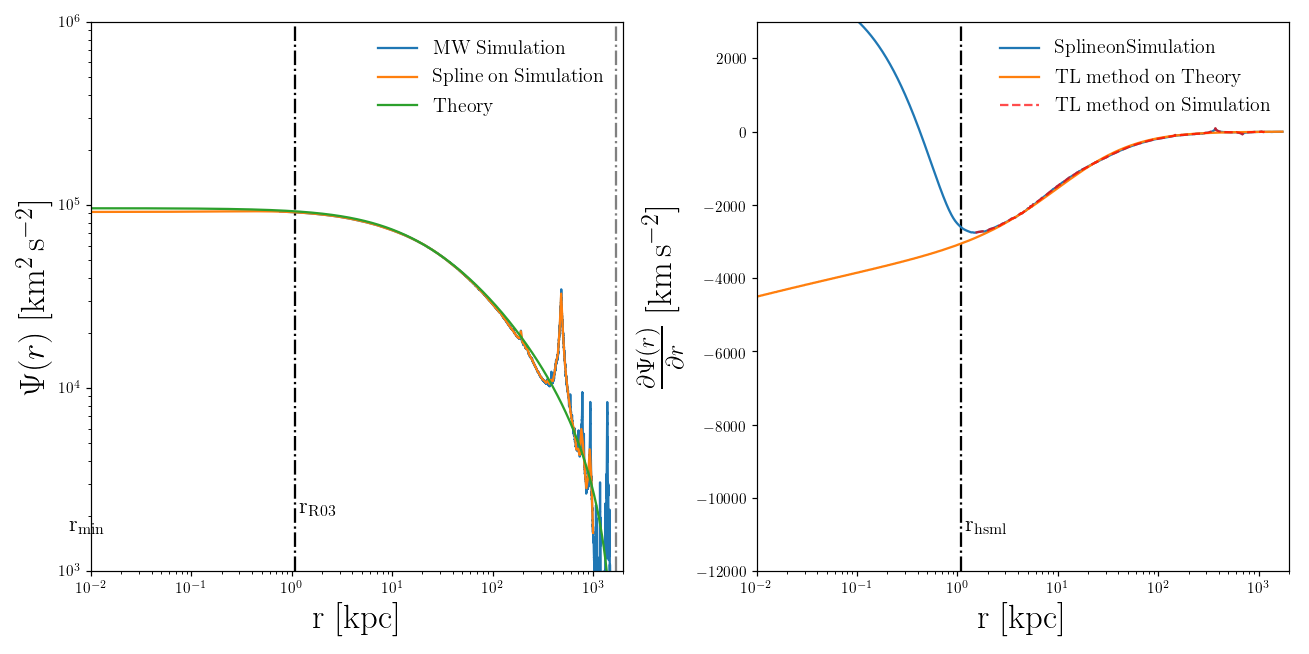

In [83]:
fig, [ax,ax1]= plt.subplots(1,2,figsize=[12,6])
ax.set_xscale('log')
ax.set_yscale('log')
ax1.set_xscale('log')
ax.set_xlabel(r'$\mathrm{r \;[kpc]}$', fontsize=23)
ax.set_ylabel(r'$\Psi(r)\mathrm{\;[km^2 \, s^{-2}]}$', fontsize=23)
ax.set_xlim([0.01,2000])
ax.set_ylim([1e3,1e6])
beg = 610
endo = 980

ax.plot(r_averaged, Psi_averaged,label=r"$\rm MW\; Simulation$")
#ax.scatter(r_sor,Psi_sor,s=4,c='gray', alpha=0.7)
ax.axvline(x=R_P03,c='k',ls='-.')
ax.text(1.1*R_P03,2e3,r'$\rm r_{R03}$',fontsize=15)

r_sampled2 =np.logspace(-2,3,300)
ax.plot(r_sampled2, spl(r_sampled2),label=r"$\rm Spline \;on\; Simulation$")
ax.plot(Psi_r_the[:,0],Psi_r_the[:,1],label=r"$\rm Theory$")

leg = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=13)
leg.get_frame().set_linewidth(0.0)
ax.axvline(x=myDMO.dm.r.min(),c='gray',ls='-')
ax.text(0.4*myDMO.dm.r.min(),2e3,r'$\rm r_{min}$',fontsize=15)
ax.axvline(x=dmo.rmax,c='gray',ls='-.')


## second panel
ax1.set_xlim([0.01,2000])
ax1.set_ylim([-12e3,3e3])
ax1.axvline(x=R_P03,c='k',ls='-.')
ax1.text(1.1*R_P03,-11e3,r'$\rm r_{hsml}$',fontsize=15)
ax1.axvline(x=myDMO.dm.r.min(),c='gray',ls='-')
ax1.text(0.4*myDMO.dm.r.min(),-11e3,r'$\rm r_{min}$',fontsize=15)


G = myDMO.p.G*myDMO.p.kpctokm**3




r_plot = 10**np.linspace(np.log10(1e-3),np.log10(times*hydro.rmax),1000) #kpc    #don't go exactly to R_max, otherwise the interpolation may fail at the edge due to round-up numbers; it's not a problem

ax1.plot(r_plot,Psi_prime_Spline(r_plot),label=r"$\rm Spline on Simulation$")

ax1.plot(r_plot, Psi_prime_num(r_plot),label=r"$\rm TL\;method\;on\;Theory$" )
r_plot = 10**np.linspace(np.log10(r_averaged[20]),np.log10(times*hydro.rmax),1000) #kpc    #don't go exactly to R_max, otherwise the interpolation may fail at the edge due to round-up numbers; it's not a problem

ax1.plot(r_plot, Psi_prime_num_S(r_plot),c='r',ls='--',alpha=0.7, label=r"$\rm TL\;method\;on\;Simulation$" )



ax1.set_xlabel('$\mathrm{r \;[kpc]}$', fontsize=23)
ax1.set_ylabel(r'$\frac{\partial\Psi(r)}{\partial r}\mathrm{\;[km\, s^{-2}]}$', fontsize=23)
plt.tight_layout()
leg = ax1.legend(loc='upper right', ncol=1, shadow=False, fontsize=13)
leg.get_frame().set_linewidth(0.0)
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/"+dmo.namenospace+"/Psi_n_PsiPrime"+dmo.namenospace+"_DMO.pdf")

In [84]:
sorted_by_r = np.argsort(myDMO.dm.r)
r_sor = myDMO.dm.r[sorted_by_r]
v_sor = myDMO.dm.v[sorted_by_r]
Psi_sor = maxval-Phy[sorted_by_r]
inside = np.where((r_sor>0.1)&(r_sor<dmo.rmax))
#making and equidistant array
part_per_bin = 1000
N_total = len(r_sor[inside])


##
dfdx_particle = derivative(spl,r_sor[inside])
ep_sor = Psi_sor[inside] - (v_sor[inside]**2)/2.
ep_tmp = ep_sor[np.argsort(ep_sor)]
ep_tmp = ep_tmp[ep_tmp>0]
equi_bins = ep_tmp[range(0,len(ep_tmp),5000)]
bin_num = 300
bins = np.linspace(0,ep_sor.max(),bin_num)

w = -dfdx_particle/((4.*np.pi)**2) / (r_sor[inside]**2) / (v_sor[inside])
dNdE, E = np.histogram(ep_sor,bins=equi_bins,weights=w)
dNdE2, E2 = np.histogram(ep_sor,bins=bins,weights=w)

E_width = E[1:]-E[:-1]
E_center = (E[1:]+E[:-1])/2.

E_width2 = E2[1:]-E2[:-1]
E_center2 = (E2[1:]+E2[:-1])/2.

In [85]:
sorted_by_r = np.argsort(myDMO.dm.r)
r_sor = myDMO.dm.r[sorted_by_r]
v_sor = myDMO.dm.v[sorted_by_r]

inside = np.where((r_sor>0.1)&(r_sor<0.9*dmo.rmax))
#making and equidistant array
part_per_bin = 1000
N_total = len(r_sor[inside])


##
dfdx_particle2 = Psi_prime_num(r_sor[inside])
ep_sor_the = Psi_interp(r_sor[inside])  - (v_sor[inside]**2)/2.
ep_tmp = ep_sor_the[np.argsort(ep_sor_the)]
ep_tmp = ep_tmp[ep_tmp>0]
equi_bins = ep_tmp[range(0,len(ep_tmp),5000)]
bin_num = 300
bins = np.linspace(0,ep_sor.max(),bin_num)

w_the = -dfdx_particle2/((4.*np.pi)**2) / (r_sor[inside]**2) / (v_sor[inside])
dNdEE, E = np.histogram(ep_sor_the,bins=equi_bins,weights=w_the)
dNdEE2, E2 = np.histogram(ep_sor_the,bins=bins,weights=w_the)

EE_width = E[1:]-E[:-1]
EE_center = (E[1:]+E[:-1])/2.

EE_width2 = E2[1:]-E2[:-1]
EE_center2 = (E2[1:]+E2[:-1])/2.

In [86]:
"""
fig, [ax,ax1,ax2] = plt.subplots(3,1,sharex=True,figsize=[7,15])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e3,3e5)
#ax.set_xlabel(r'$\mathrm{r \;[kpc]}$', fontsize=23)
ax.set_ylabel(r'$\mathcal{E}$', fontsize=23)
ax.axvline(x=R_P03,c='k',ls='--')
ax.axvline(x=myhydro.r200,c='k',ls='--')
ax.axvline(x=hydro.rmax,c='k',ls='--')

fig.tight_layout()
ax.scatter(r_sor[inside],ep_sor,alpha=0.5,s=1,label= r"$\rm Simulation$")
ax.scatter(r_sor[inside],ep_sor_the,alpha=0.1,s=1,label= r"$\rm Theory$")
leg = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=13)

leg.get_frame().set_linewidth(0.0)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.axvline(x=R_P03,c='k',ls='--')
ax1.axvline(x=myhydro.r200,c='k',ls='--')
ax1.axvline(x=hydro.rmax,c='k',ls='--')
ax1.set_ylabel(r'$\frac{-\Psi^{\prime}(r)}{(4\pi)^2 \,r^2\, v}$', fontsize=23)
ax1.text(5,1,r"$\rm The \;weights$",fontsize=25)
fig.tight_layout()
ax1.scatter(r_sor[inside],w,alpha=0.5,s=1,label= r"$\rm Simulation$")
ax1.scatter(r_sor[inside],w_the,alpha=0.1,s=1,label= r"$\rm Theory$")
leg = ax1.legend(loc='lower left', ncol=1, shadow=False, fontsize=13)

leg.get_frame().set_linewidth(0.0)

ax2.set_xscale('log')
ax2.set_ylabel(r'$\Psi^{\prime}$', fontsize=23)
ax2.set_xlabel(r'$\mathrm{r \;[kpc]}$', fontsize=23)
ax2.axvline(x=R_P03,c='k',ls='--')
ax2.axvline(x=myhydro.r200,c='k',ls='--')
ax2.axvline(x=hydro.rmax,c='k',ls='--')
ax2.scatter(r_sor[inside], dfdx_particle,label= r"$\rm Simulation$")
ax2.scatter(r_sor[inside], dfdx_particle2,label= r"$\rm Theory$")
leg = ax2.legend(loc='lower rigt', ncol=1, shadow=False, fontsize=13)

leg.get_frame().set_linewidth(0.0)
fig.tight_layout(h_pad=-0.7)
#plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/"+hydro.namenospace+"/E_ingredients"+hydro.namenospace+"_DMO.png")
"""

'\nfig, [ax,ax1,ax2] = plt.subplots(3,1,sharex=True,figsize=[7,15])\nax.set_xscale(\'log\')\nax.set_yscale(\'log\')\nax.set_ylim(1e3,3e5)\n#ax.set_xlabel(r\'$\\mathrm{r \\;[kpc]}$\', fontsize=23)\nax.set_ylabel(r\'$\\mathcal{E}$\', fontsize=23)\nax.axvline(x=R_P03,c=\'k\',ls=\'--\')\nax.axvline(x=myhydro.r200,c=\'k\',ls=\'--\')\nax.axvline(x=hydro.rmax,c=\'k\',ls=\'--\')\n\nfig.tight_layout()\nax.scatter(r_sor[inside],ep_sor,alpha=0.5,s=1,label= r"$\rm Simulation$")\nax.scatter(r_sor[inside],ep_sor_the,alpha=0.1,s=1,label= r"$\rm Theory$")\nleg = ax.legend(loc=\'upper right\', ncol=1, shadow=False, fontsize=13)\n\nleg.get_frame().set_linewidth(0.0)\n\nax1.set_xscale(\'log\')\nax1.set_yscale(\'log\')\nax1.axvline(x=R_P03,c=\'k\',ls=\'--\')\nax1.axvline(x=myhydro.r200,c=\'k\',ls=\'--\')\nax1.axvline(x=hydro.rmax,c=\'k\',ls=\'--\')\nax1.set_ylabel(r\'$\x0crac{-\\Psi^{\\prime}(r)}{(4\\pi)^2 \\,r^2\\, v}$\', fontsize=23)\nax1.text(5,1,r"$\rm The \\;weights$",fontsize=25)\nfig.tight_layout()

In [87]:
xpoints = Epsilon.reshape(1,len(Epsilon)*len(Epsilon[0]))
points = N_bins_method2.reshape(1,len(N_bins)*len(N_bins[0]))
colors = R.reshape(1,len(R)*len(R[0]))

errpoints = DN_bins.reshape(1,len(DN_bins)*len(DN_bins[0]))

<IPython.core.display.Javascript object>


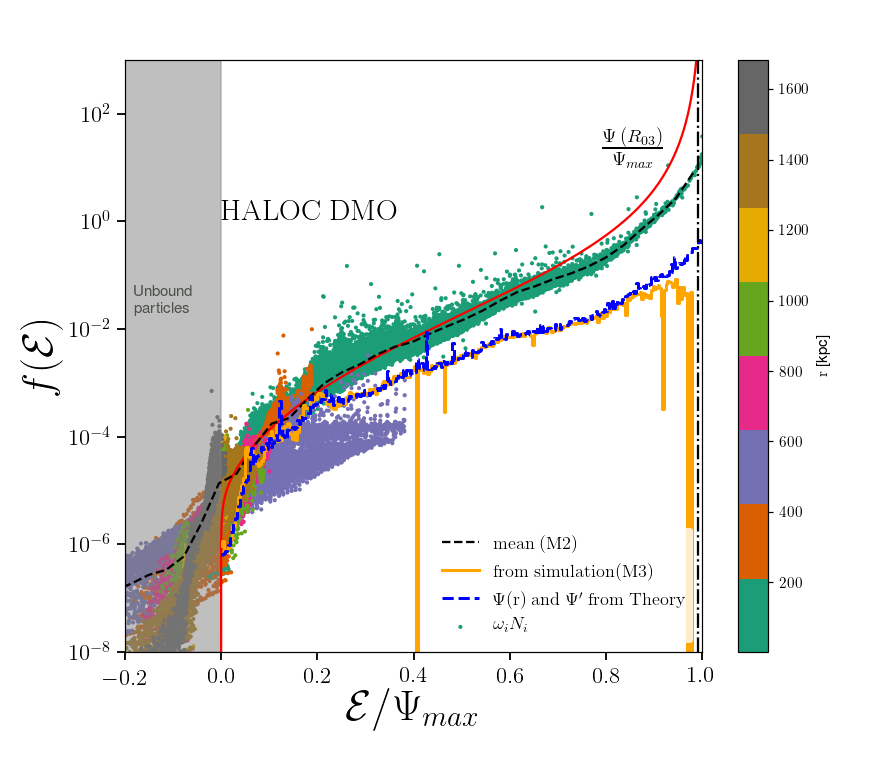

In [88]:

fig, ax = plt.subplots(figsize=[8,7])
fig.tight_layout(rect=[0.09, 0.09, 1, 0.95])
cmap = plt.cm.get_cmap('Dark2')
ax.set_xlabel(r'$\mathcal{E}/ \Psi_{max}$',fontsize=28)
ax.set_ylabel(r'$f(\mathcal{E}) $',fontsize=28)
ax.set_ylim([1e-8,1e3])
ax.set_xlim([-0.2,1])
ax.set_yscale('log')
#ax.set_xscale('log')

ax.axvspan(xmin=-0.3,xmax=0,color='gray',alpha=0.5)

ax.plot(f_E_Theory[:,0],f_E_Theory[:,1],'r')
normalize = mpl.colors.Normalize(vmin=np.nanmin(colors[0]), vmax=np.nanmax(colors[0]))
mapa = [cmap(normalize(value)) for value in np.nan_to_num(colors[0])]
sc = ax.scatter(xpoints/Psi.max(), points, s=3,zorder=0,c=mapa,label=r"$\omega_i N_i$")
cax, _ = mpl.colorbar.make_axes(ax)

cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize,label=r"$\rm r$ [kpc]")

#ax.scatter(E_tilde[unbounded]/Psi.max(), N_tilde[unbounded],label="Unbounded bins")
#ax.plot(ep_array_center/Psi.max(), mean_fE_bounded,'k--', label="mean of the unbounded data")
ax.plot(ep_array_center/themaxofPsiDMO, mean_all,'k--', label=r"$\rm mean \;(M2)$")

ax.step( E_center2 / Psi_averaged.max(),dNdE2/ E_width2 ,linewidth=2,c='orange',
        label=r"$\rm from\; simulation(M3)$")
ax.step( EE_center2 / Psi_averaged.max(),dNdEE2/ EE_width2 ,color='b',linestyle='--',
        linewidth=2,label=r"$\rm \Psi(r)\; and\; \Psi^{\prime} \;from\; Theory $  ")
diff = np.abs(r_averaged- R_P03)
res_lim =Psi_averaged[(diff == diff.min()) ][0]/ Psi_averaged.max()

ax.axvline(x=res_lim,c='k',ls='-.')
ax.text(0.8*res_lim,1e1,r"$\frac{\Psi\,(R_{03})}{\Psi_{max}}$",fontsize=18)
#ax.axvline(x=resolutiont_limit_in_epsilon,color='k',linestyle='-.')
#ax.axvline(x=resolutiont_limit_in_epsilon,color='k',linestyle='-.')
ax.text(-0.18,2e-2,"Unbound\nparticles",color='#4b5149')
ax.text(0,1,r"$\rm "+dmo.namenospace+"\;"+dmo.version+"$", fontsize=20)

leg = ax.legend(loc='lower right', ncol=1, shadow=False, fontsize=12)

leg.get_frame().set_linewidth(0.0)
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/"+dmo.namenospace+"/F_of_E_"+dmo.namenospace+"DMO_2Methods.pdf")


In [89]:
print Psi_averaged[(diff == diff.min()) ]
Psi_averaged.max()

[91090.515625]


91950.71875